In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../spatial-clust-scripts-main/")
import utils
from sklearn.decomposition import PCA
import umap
import graph
#import visualize
import sklearn.metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="anndata")

In [7]:
stlearn = pd.read_csv('../../data/liv/liver_stlearn_pca30v2.csv', index_col=1).to_numpy()
sedr = pd.read_csv('../../data/liv/cosliv_sedr_32n_v2.csv', index_col=1).to_numpy()
spagcn = np.load('../../data/liv/conv_output_epoch_200.npy')
banksy = pd.read_csv('../../data/liv/cellsnap_data_liv_banksy_r1-all.csv').loc[:, 'PC1':'PC20'].to_numpy()
cellc = pd.read_csv('../../data/liv/CC_liv_30x4.csv').to_numpy()

print([stlearn.shape, sedr.shape, spagcn.shape, banksy.shape, cellc.shape])

[(54867, 30), (54867, 32), (54867, 30), (54867, 20), (54867, 120)]


In [8]:
arrays = [stlearn, sedr, spagcn, banksy, cellc]

# Check for NaN values in each array
nan_checks = [np.isnan(arr).any() for arr in arrays]

# Print the shapes and NaN checks together
for i, (shape, has_nan) in enumerate(zip([arr.shape for arr in arrays], nan_checks)):
    print(f"Array {i+1} shape: {shape}, Contains NaN: {has_nan}")

Array 1 shape: (54867, 30), Contains NaN: False
Array 2 shape: (54867, 32), Contains NaN: False
Array 3 shape: (54867, 30), Contains NaN: False
Array 4 shape: (54867, 20), Contains NaN: False
Array 5 shape: (54867, 120), Contains NaN: False


In [9]:
import warnings
warnings.filterwarnings('ignore')
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(stlearn.shape[0], 10000, replace=False)
    
    stlearn_sub = stlearn[indices]
    sedr_sub = sedr[indices]
    spagcn_sub = spagcn[indices]
    banksy_sub = banksy[indices]
    cellc_sub = cellc[indices]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    stlearn_ss_list = []
    sedr_ss_list = []
    spagcn_ss_list = []
    banksy_ss_list = []
    cellc_ss_list = []

    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## stlearn
        stlearn_edges = graph.get_feature_edges(
            arr=stlearn_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        stlearn_labels = graph.graph_clustering(
            stlearn_sub.shape[0], stlearn_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## sedr
        sedr_edges = graph.get_feature_edges(
            arr=sedr_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        sedr_labels = graph.graph_clustering(
            sedr_sub.shape[0], sedr_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## spagcn
        spagcn_edges = graph.get_feature_edges(
            arr=spagcn_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        spagcn_labels = graph.graph_clustering(
            spagcn_sub.shape[0], spagcn_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## banksy
        banksy_edges = graph.get_feature_edges(
            arr=banksy_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        banksy_labels = graph.graph_clustering(
            banksy_sub.shape[0], banksy_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## cellcharter
        cellc_edges = graph.get_feature_edges(
            arr=cellc_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        cellc_labels = graph.graph_clustering(
            cellc_sub.shape[0], cellc_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        stlearn_ss = sklearn.metrics.davies_bouldin_score(stlearn_sub, stlearn_labels)
        sedr_ss = sklearn.metrics.davies_bouldin_score(sedr_sub, sedr_labels)
        spagcn_ss = sklearn.metrics.davies_bouldin_score(spagcn_sub, spagcn_labels)
        banksy_ss = sklearn.metrics.davies_bouldin_score(banksy_sub, banksy_labels)
        cellc_ss = sklearn.metrics.davies_bouldin_score(cellc_sub, cellc_labels)

        stlearn_ss_list.append(stlearn_ss)
        sedr_ss_list.append(sedr_ss)
        spagcn_ss_list.append(spagcn_ss)
        banksy_ss_list.append(banksy_ss)
        cellc_ss_list.append(cellc_ss)
        
    data = {'k':k_clusters, 'ch_stlearn':stlearn_ss_list, 'ch_sedr':sedr_ss_list, 'ch_spagcn':spagcn_ss_list,
           'ch_banksy':banksy_ss_list, 'ch_cellc':cellc_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['ch_stlearn', 'ch_sedr', 'ch_spagcn', 'ch_banksy', 'ch_cellc'])
test2.to_csv('../../data/liv/DB_result_liver_revloc.csv')

at 0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


at 1
at 2
at 3
at 4


<Axes: xlabel='k', ylabel='value'>

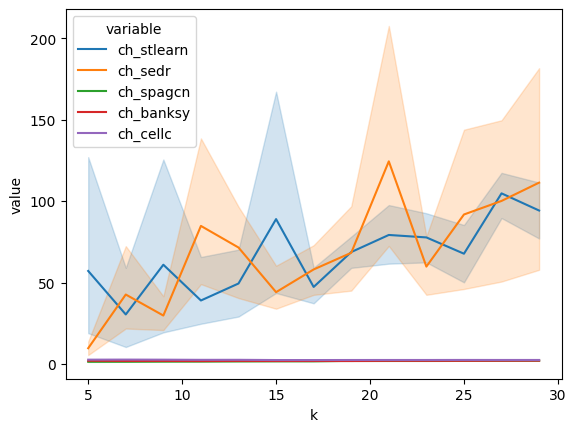

In [10]:
df = test2
sns.lineplot(data=df, x="k", y="value", hue="variable")

In [7]:
np.min(test2.value)

0      76.413980
1      31.229869
2      21.369709
3      21.755154
4      48.475794
         ...    
320     2.411907
321     2.428036
322     2.484538
323     2.443696
324     2.417177
Name: value, Length: 325, dtype: float64

In [3]:
cca = pd.read_csv('../data/cca11_feat.csv').to_numpy()
mofa = pd.read_csv('../data/mofa_fc24.csv').to_numpy()
print([cca.shape, mofa.shape])

[(54867, 11), (102574, 24)]


In [4]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(cca.shape[0], 10000, replace=False)
    
    cca_sub = cca[indices]
    mofa_sub = mofa[indices]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    cca_ss_list = []
    mofa_ss_list = []

    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## cca
        cca_edges = graph.get_feature_edges(
            arr=cca_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        cca_labels = graph.graph_clustering(
            cca_sub.shape[0], cca_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## mofa
        mofa_edges = graph.get_feature_edges(
            arr=mofa_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        mofa_labels = graph.graph_clustering(
            mofa_sub.shape[0], mofa_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        cca_ss = sklearn.metrics.davies_bouldin_score(cca_sub, cca_labels)
        mofa_ss = sklearn.metrics.davies_bouldin_score(mofa_sub, mofa_labels)

        cca_ss_list.append(cca_ss)
        mofa_ss_list.append(mofa_ss)
        
    data = {'k':k_clusters, 'ch_cca':cca_ss_list,
            'ch_mofa':mofa_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['ch_cca', 'ch_mofa'])
test2.to_csv('../data/DB_result_liver_ccamofa.csv')


at 0
at 1
at 2
at 3
at 4


In [2]:
# read in files
snap_embed = np.load('../data/469_double_snap_combo_stable_0325.npy')
features = np.load('../data/469_pc.npy')[:,:30]
concact_embed = np.load("../data/469_concact.npy")
spice_embed = np.load("../data/spicemix_469_embedding.npy")

##### load in muse 0-4 batch results
muse_embed0 = np.load("../data/muse_469_embedding_batch_0.npy")
muse_embed1 = np.load("../data/muse_469_embedding_batch_1.npy")
muse_embed2 = np.load("../data/muse_469_embedding_batch_2.npy")
muse_embed3 = np.load("../data/muse_469_embedding_batch_3.npy")
muse_embed4 = np.load("../data/muse_469_embedding_batch_4.npy")
muse_embedll = [muse_embed0, muse_embed1, muse_embed2, muse_embed3, muse_embed4]

print([snap_embed.shape, features.shape, concact_embed.shape,
      spice_embed.shape, muse_embed0.shape])

[(54867, 32), (54867, 30), (54867, 41), (54867, 30), (10000, 30)]


In [3]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(snap_embed.shape[0], 10000, replace=False)
    
    snap_embed_sub = snap_embed[indices]
    features_sub = features[indices]
    concact_embed_sub = concact_embed[indices]
    spice_embed_sub = spice_embed[indices]
    muse_embed_sub = muse_embedll[i]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    feature_ss_list = []
    snap_ss_list = []
    concact_ss_list = []
    spice_ss_list = []
    muse_ss_list = []
    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## feature
        feature_edges = graph.get_feature_edges(
            arr=features_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        feature_labels = graph.graph_clustering(
            features_sub.shape[0], feature_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## snap
        snap_edges = graph.get_feature_edges(
            arr=snap_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        snap_labels = graph.graph_clustering(
            snap_embed_sub.shape[0], snap_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## concact 
        concact_edges = graph.get_feature_edges(
            arr=concact_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        concact_labels = graph.graph_clustering(
            concact_embed_sub.shape[0], concact_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        ## muse 
        muse_edges = graph.get_feature_edges(
            arr=muse_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        muse_labels = graph.graph_clustering(
            muse_embed_sub.shape[0], muse_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        ## spice 
        spice_edges = graph.get_feature_edges(
            arr=spice_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        spice_labels = graph.graph_clustering(
            spice_embed_sub.shape[0], spice_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        feature_ss = sklearn.metrics.davies_bouldin_score(features_sub, feature_labels)
        snap_ss = sklearn.metrics.davies_bouldin_score(snap_embed_sub, snap_labels)
        concact_ss = sklearn.metrics.davies_bouldin_score(concact_embed_sub, concact_labels)
        spice_ss = sklearn.metrics.davies_bouldin_score(spice_embed_sub, spice_labels)
        muse_ss = sklearn.metrics.davies_bouldin_score(muse_embed_sub, muse_labels)

        feature_ss_list.append(feature_ss)
        snap_ss_list.append(snap_ss)
        concact_ss_list.append(concact_ss)
        spice_ss_list.append(spice_ss)
        muse_ss_list.append(muse_ss)
        
    data = {'k':k_clusters, 'ch_feature':feature_ss_list,
            'ch_snap':snap_ss_list,'ch_concact':concact_ss_list,
           'ch_spice':spice_ss_list, 'ch_muse':muse_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    


at 0
at 1
at 2
at 3
at 4


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


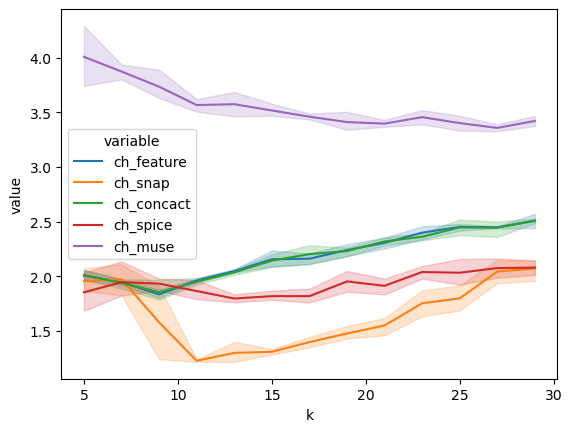

In [4]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['ch_feature', 'ch_snap', 'ch_concact', 'ch_spice', 'ch_muse'])
test2.to_csv('../data/DB_result_liv_0325.csv')

plot = sns.lineplot(data=test2,x="k", y="value", hue="variable")
fig = plot.get_figure()
#fig.savefig('../plots/CH_allmethods_dbGNNstab.svg', dpi = 300) 
